In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
import time
import torch
from torch.functional import Tensor
from tqdm import tqdm
from collections import OrderedDict
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torchvision
import shutil

from skimage.metrics import peak_signal_noise_ratio as get_psnr
from skimage.metrics import structural_similarity as get_ssim

# my library
from model import RCAN
from data_loader import get_loader
from utils import get_gpu_memory, sec2time

In [14]:
class Config:
    def __init__(self):
        self.version = '201209_RCAN'
        self.mode = 'original'
        self.height = 128
        self.width = 128
        self.batch_size = 4
        self.num_epochs = 200
        self.save_image_every = 100
        self.save_model_every = 10
        self.scale_factor = 2
        self.augment = True  # if True, random crop from image, else, center crop


config = Config()
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [15]:
train_loader, test_loader = get_loader(h=config.height, w=config.width, scale_factor=config.scale_factor,
                                       augment=config.augment, device=device, batch_size=config.batch_size)


In [90]:
for lr, hr, _ in tqdm(test_loader):
    lr = lr
    hr = hr
    break

  0%|                                                                                               | 0/25 [00:00<?, ?it/s]


In [21]:
import torch.fft as fft

In [24]:
lr.shape

torch.Size([4, 3, 64, 64])

In [30]:
F = fft.fftn(lr[0,])
F.shape

torch.Size([3, 64, 64])

In [33]:
F.cpu().numpy()

array([[[ 3.58961572e+03+0.00000000e+00j,
          6.57287598e+02+8.17827515e+02j,
          7.71832123e+01-9.49420471e+01j, ...,
          1.45452271e+02+6.96832371e+00j,
          7.71832123e+01+9.49420471e+01j,
          6.57287598e+02-8.17827454e+02j],
        [-1.44970688e+02+8.72900391e+02j,
          1.03974304e+02+2.16679504e+02j,
          1.53508331e+02-2.50061178e+00j, ...,
         -1.38250702e+02+4.36591858e+02j,
         -2.59346497e+02+6.32761612e+01j,
          4.86668152e+02+4.39836975e+02j],
        [ 1.56016968e+02+3.01196808e+02j,
          7.82767868e+01+1.51306183e+02j,
          6.97966385e+00+4.19594460e+01j, ...,
         -6.55735092e+01-9.36855774e+01j,
         -2.16906952e+02+3.70021057e+01j,
         -5.25597763e+01-1.85089417e+02j],
        ...,
        [-2.10324326e+01-1.12571419e+02j,
         -1.90474930e+02-1.09784546e+02j,
         -1.06061735e+01-8.01400909e+01j, ...,
          8.32795105e+01+3.50909500e+01j,
          1.17789917e+02+6.17007971e+00j

In [39]:
import numpy as np
import matplotlib.pylab as plt

In [75]:
A= lr.cpu().numpy()[1]
img = np.transpose(A, (1,2,0))

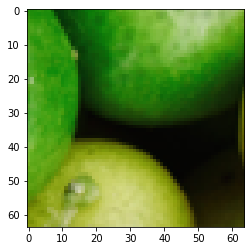

In [76]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


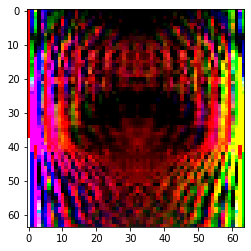

In [77]:
F = np.fft.fft2(img)
plt.imshow(F.real)

In [81]:
IF = np.fft.ifft2(F)

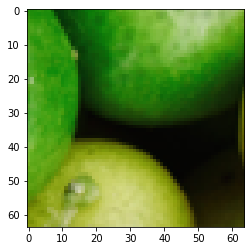

In [79]:
plt.imshow(IF.real)

In [84]:
np.sum(IF.real == img)/(64**2*3)

0.555908203125

In [119]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift

#do the 2D fourier transform
fft_img = fftshift(fft2(img))

# reverse the 2D fourier transform
freq_filt_img = ifft2(ifftshift(fft_img))

freq_filt_img = np.abs(freq_filt_img)


In [139]:
ff1 = fft2(np.transpose(img, (2,0,1)))
ff1.shape

(3, 64, 64)

In [140]:
ff2 = fft2(img[...,0])
ff2.shape

(64, 64)

In [141]:
ff1[0,...] == ff2

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [144]:
ff2, ff2.shape

(array([[ 1.18077650e+03  +0.j        , -1.37892124e+02 -84.52934652j,
          8.16015364e+01 -78.8973923j , ...,
          1.34011184e+01 +49.10673969j,  8.16015364e+01 +78.8973923j ,
         -1.37892124e+02 +84.52934652j],
        [ 3.58382107e+02+210.33581704j,  1.10611522e+02 -10.88048652j,
         -3.21962882e+01 +17.32091957j, ...,
         -3.97415825e-01 -11.48612982j,  1.05138269e+00 +30.08218663j,
         -3.36049470e+02-173.50415645j],
        [-2.04469875e+01 +76.88315618j,  1.50729449e+02 +18.44816871j,
          1.96899243e+01 +32.89390778j, ...,
          1.57152262e+01 +10.0722051j , -3.40273155e+01 +38.25791835j,
         -3.09267547e+01-153.46985473j],
        ...,
        [ 2.90104189e+00  -0.72313017j, -3.39032628e+01 -21.02669974j,
         -3.98494870e+01 +33.61339838j, ...,
          9.06164952e+00 -25.24886044j,  2.70642007e+01 -37.4737057j ,
          6.87662649e+01 +27.10628705j],
        [-2.04469875e+01 -76.88315618j, -3.09267547e+01+153.46985473j,
    

In [148]:
fft.fftn(lr[1,0]) , fft.fftn(lr[1,0]).shape

(tensor([[ 1.1808e+03+0.0000j, -1.3789e+02-84.5293j,  8.1602e+01-78.8974j,
           ...,  1.3401e+01+49.1067j,  8.1602e+01+78.8974j,
          -1.3789e+02+84.5294j],
         [ 3.5838e+02+210.3358j,  1.1061e+02-10.8805j, -3.2196e+01+17.3209j,
           ..., -3.9742e-01-11.4861j,  1.0514e+00+30.0822j,
          -3.3605e+02-173.5042j],
         [-2.0447e+01+76.8831j,  1.5073e+02+18.4482j,  1.9690e+01+32.8939j,
           ...,  1.5715e+01+10.0722j, -3.4027e+01+38.2579j,
          -3.0927e+01-153.4698j],
         ...,
         [ 2.9010e+00-0.7231j, -3.3903e+01-21.0267j, -3.9849e+01+33.6134j,
           ...,  9.0616e+00-25.2489j,  2.7064e+01-37.4737j,
           6.8766e+01+27.1063j],
         [-2.0447e+01-76.8831j, -3.0927e+01+153.4698j, -3.4027e+01-38.2579j,
           ...,  4.7830e+00-6.8383j,  1.9690e+01-32.8939j,
           1.5073e+02-18.4482j],
         [ 3.5838e+02-210.3358j, -3.3605e+02+173.5042j,  1.0514e+00-30.0822j,
           ..., -2.1823e+01-21.0375j, -3.2196e+01-17.3209j,
  

In [157]:
f1 = fft.fftn(lr, dim=(2,3))
f2 = fft.fftn(lr[0,0])
f1.shape, f2.shape



(torch.Size([4, 3, 64, 64]), torch.Size([64, 64]))

In [158]:
f1[0,0] == f2

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [164]:
fft.ifftn(f2).real 

tensor([[0.0784, 0.1098, 0.1490,  ..., 0.3961, 0.4000, 0.4039],
        [0.0824, 0.1020, 0.1333,  ..., 0.4039, 0.4000, 0.4039],
        [0.0745, 0.0941, 0.1294,  ..., 0.4000, 0.3804, 0.3843],
        ...,
        [0.8392, 0.8431, 0.8471,  ..., 0.6039, 0.6235, 0.6431],
        [0.8353, 0.8510, 0.8431,  ..., 0.6588, 0.6667, 0.6275],
        [0.8314, 0.8471, 0.8627,  ..., 0.6627, 0.6392, 0.5961]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [165]:
lr[0,0]

tensor([[0.0784, 0.1098, 0.1490,  ..., 0.3961, 0.4000, 0.4039],
        [0.0824, 0.1020, 0.1333,  ..., 0.4039, 0.4000, 0.4039],
        [0.0745, 0.0941, 0.1294,  ..., 0.4000, 0.3804, 0.3843],
        ...,
        [0.8392, 0.8431, 0.8471,  ..., 0.6039, 0.6235, 0.6431],
        [0.8353, 0.8510, 0.8431,  ..., 0.6588, 0.6667, 0.6275],
        [0.8314, 0.8471, 0.8627,  ..., 0.6627, 0.6392, 0.5961]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [168]:
f1.imag

tensor([[[[ 0.0000e+00,  3.2750e+02, -2.0796e+01,  ..., -1.3447e+01,
            2.0796e+01, -3.2750e+02],
          [ 3.0929e+02,  7.0363e+01, -3.1781e+00,  ...,  1.5356e+02,
            6.4206e+00,  1.5470e+02],
          [ 1.1562e+02,  6.4536e+01,  1.4934e+01,  ..., -3.3261e+01,
            1.2661e+01, -6.5829e+01],
          ...,
          [-3.5335e+01, -3.9146e+01, -2.5006e+01,  ...,  1.1385e+01,
            6.8387e+00,  7.2212e+00],
          [-1.1562e+02,  6.5829e+01, -1.2661e+01,  ...,  8.1816e+00,
           -1.4934e+01, -6.4536e+01],
          [-3.0929e+02, -1.5470e+02, -6.4206e+00,  ..., -1.3806e+01,
            3.1781e+00, -7.0363e+01]],

         [[ 0.0000e+00,  2.7368e+02, -2.9913e+01,  ...,  4.1196e+00,
            2.9913e+01, -2.7368e+02],
          [ 2.8633e+02,  7.3388e+01,  6.7243e-01,  ...,  1.4508e+02,
            2.2093e+01,  1.4701e+02],
          [ 9.7628e+01,  5.1337e+01,  1.6530e+01,  ..., -3.0393e+01,
            1.2163e+01, -6.3400e+01],
          ...,
     

In [170]:
torch.imag()

TypeError: imag() missing 1 required positional arguments: "input"

In [172]:
config.mode = "aa"
weight_dir = f'./weights/{config.version}/{config.mode}'
if os.path.isdir(weight_dir):
    shutil.rmtree(weight_dir)
os.makedirs(weight_dir, exist_ok=True)